**EM. Восстановление смеси плотностей распределений.**


Евгений Борисов borisov.e@solarl.ru

---

## библиотеки

In [1]:
import time

import numpy as np
import matplotlib.pyplot as plt

# from sklearn.preprocessing import MinMaxScaler
# from sklearn.model_selection import train_test_split

##  загружаем данные 

In [2]:
X = np.loadtxt('../data/400_1/points_9.txt')
n_comp = 4 # количество компонент

In [3]:
# X = np.vstack([ 
#            np.random.normal(loc=-2.0, scale=1.0, size=[200,2]),
#            np.random.normal(loc=2.0, scale=1.0, size=[200,2]),
#        ])
# 
# n_comp = 2 # количество компонент

### рисуем данные


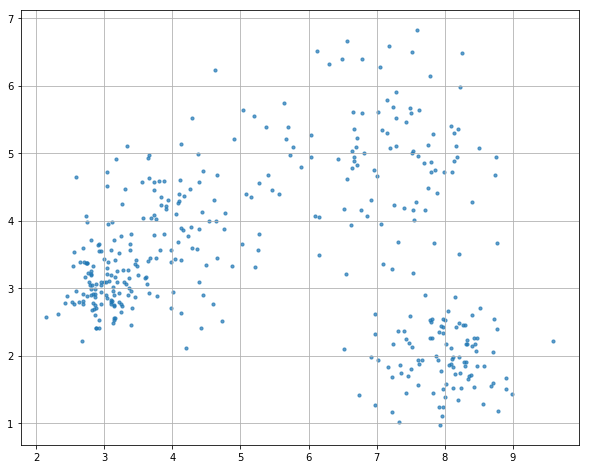

In [36]:
# plot_frame = np.vstack( [ X.min(axis=0),X.max(axis=0) ])+ np.array([ [ -1.0,-1.0], [ 1.0,1.0] ] )
# plt.xlim(plot_frame[:,0])
# plt.ylim(plot_frame[:,1])

plt.gcf().set_size_inches(10,8)
plt.scatter( X[:,0], X[:,1],s=10,alpha=0.7)
plt.grid()
plt.show()

## инициализация параметров

In [10]:
# инициализация генератора псевдослучайных чисел
np.random.seed(seed= int((time.time() % 1)*1e7) )

In [11]:
# матрицы ковариаций признаков для каждой компоненты смеси
S = np.cov(X.T)
S = [ S for i in range(n_comp) ]

# начальные веса компонент (априорная вероятность)
w = np.ones(n_comp) / n_comp 

# мат.ожидания для компонент смеси
# mu = [ np.random.rand(X.shape[1])  for i in range(n_comp) ]*np.max(X,axis=0)

mu = np.vstack( [ 
                    np.mean(X,axis=0),
                    [ np.random.rand(X.shape[1])  for i in range(1,n_comp) ]*np.max(X,axis=0)
                ] )


In [12]:
mu

array([[5.49262583, 3.46744197],
       [6.16543426, 3.53656972],
       [3.16580505, 2.36645894],
       [4.84987253, 1.34413603]])

---

In [20]:
def plot_mix( S, mu, b=2.0):
    # рисуем мат.ожидание
    mu_ = np.vstack(mu)
    plt.scatter( mu_[:,0], mu_[:,1],s=30,alpha=0.7)

    # рисуем проекцию гауссианы
    a = np.linspace(0.0,2.0,20)*np.pi 
    c = np.array([ np.cos(a), np.sin(a) ])
    
    for j in range(len(S)):
        s = 1.0/( 2.0*np.pi*np.sqrt( np.linalg.det(S[j]) ) ) * b
        #  собственные значения и векторы матрицы ковариаций для компоненты смеси j
        v, l = np.linalg.eig(S[j])  
        v = v*l.sum(axis=1)
        el = c * v.reshape(2,1) * s + mu[j].reshape(2,1)
        plt.plot( el[0,:] , el[1,:]  ) 

### рисуем начальное состояние

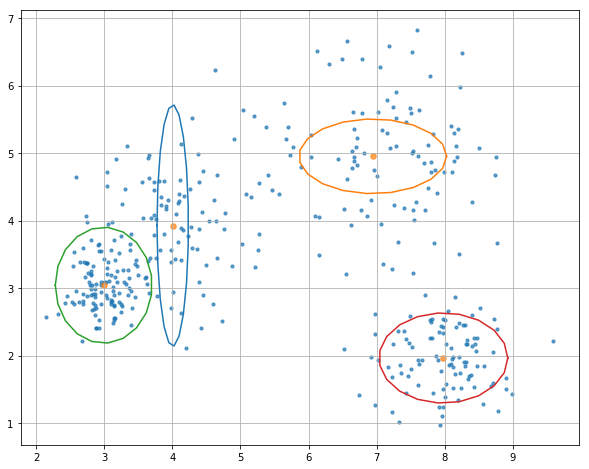

In [37]:
# plt.xlim(plot_frame[:,0])
# plt.ylim(plot_frame[:,1])
plt.gcf().set_size_inches(10,8)
plt.scatter( X[:,0], X[:,1],s=10,alpha=0.7)
plot_mix(S,mu,b=5.0)
plt.grid()
plt.show()

## оптимизация параметров

In [26]:
# фунция n-мерной нормальной плотности распределения
def dens_gauss(X,iS,dS,mu):
    n = X.shape[1] # размерность пространства
    s = 1.0 / np.sqrt( dS * np.square(2.0*np.pi)  )
    xm = X - mu
    return s*np.exp( -0.5 * (xm.dot(iS)*xm).sum(axis=1) )
    

In [27]:
# оценка параметров
def e_step( X, S, mu, w, k=n_comp ):
    m = X.shape[0] # количество учебных примеров
   
    # для для каждой компоненты смеси вычисляем ...
    # обратные матрицы ковариаций признаков 
    iS = [ np.linalg.inv(si)  for si in S ] 
    # определители матрицы ковариаций признаков 
    dS = [ np.linalg.det(si)  for si in S ] 
    
    # взвешеное значение плотности распределения для каждой точки по всем компоненитам смеси
    p = np.vstack([ dens_gauss(X,iS[j],dS[j],mu[j]) * w[j] for j in range(n_comp)] )
    
    return p/p.sum(axis=0)


In [28]:
# оптимизация параметров
def m_step(X,g):
    G_FACTOR = 1.0
    
    sg = g.sum(axis=1)
    
    w = sg/X.shape[0]   # веса компонент смеси
    
    # мат.ожидания для компонент смеси
    mu = [ ( g[j,:].reshape(X.shape[0],1) * X ).sum(axis=0) / sg[j] for j in range(n_comp) ]

    # изменяем матрицы ковариаций 
    xm = [ ( X-mu[j] ) * g[j].reshape(X.shape[0],1) for j in range(n_comp) ]
    S = [ xm[j].T.dot(xm[j]) / ( sg[j]*G_FACTOR ) for j in range(n_comp)  ]   
    
    return S, mu, w
    

In [29]:
MAX_ITER = 100 # максимальное количество циклов
G_MAX = 1e-3 # минимальное изменение оценки (критерий остановки EM)

# начальные значения оценок
g = np.zeros( [ n_comp, X.shape[0],  ]  ) 

for i in range(MAX_ITER):
    g0 = g # сохраняем старую оценку параметров
    g = e_step(X,S,mu,w) # оценка параметров
    S, mu, w = m_step(X,g) # оптимизация параметров
    
    # считаем изменение оценки
    gm = np.abs( g - g0 ).max() 
    
    assert ~np.isnan(gm), 'ошибка вычислений, неудачные начальные параметры'
   
    print("%i: %f/%f"%(i,gm,G_MAX))

    #  проверяем условия завершения работы
    if( gm < G_MAX ): break # изменение оценки ниже порога, конец работы
        


0: 0.628304/0.001000
1: 0.730588/0.001000
2: 0.651872/0.001000
3: 0.567564/0.001000
4: 0.542283/0.001000
5: 0.414742/0.001000
6: 0.456117/0.001000
7: 0.386553/0.001000
8: 0.488052/0.001000
9: 0.541404/0.001000
10: 0.290275/0.001000
11: 0.080931/0.001000
12: 0.027109/0.001000
13: 0.014252/0.001000
14: 0.008255/0.001000
15: 0.005539/0.001000
16: 0.004237/0.001000
17: 0.003351/0.001000
18: 0.002710/0.001000
19: 0.002221/0.001000
20: 0.001842/0.001000
21: 0.001540/0.001000
22: 0.001298/0.001000
23: 0.001099/0.001000
24: 0.000936/0.001000


## рисуем результат

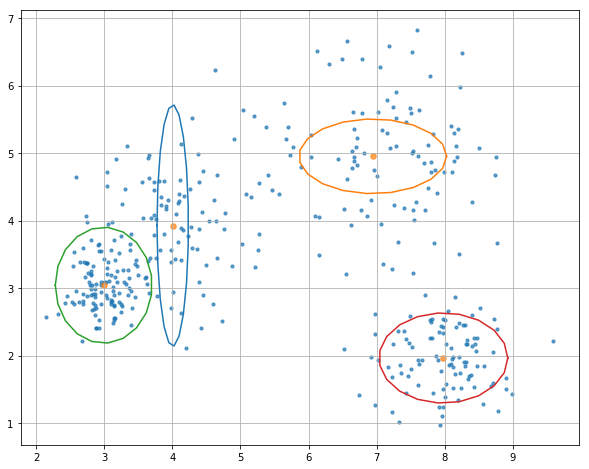

In [38]:
#plt.xlim(plot_frame[:,0])
#plt.ylim(plot_frame[:,1])
plt.gcf().set_size_inches(10,8)
plt.scatter( X[:,0], X[:,1],s=10,alpha=0.7)
plot_mix(S,mu,b=5.0)
plt.grid()
plt.show()